### Process missing weather station data

#### Fill missing ECCC station data with interpolation

In [ ]:
import pandas as pd
from pathlib import Path

def eccc_fill_wind_dir_gaps(input_csv):
    """
    Reads wind direction data, checks for gaps in 'date/time (lst)' within a 7-day threshold,
    fills missing rows, and interpolates 'winddirsde' using nearest-neighbor interpolation 
    grouped by 'climate id' and 'month'.

    Parameters:
    input_csv (str or Path): Path to the input CSV file containing required columns.
    """
    data = pd.read_csv(input_csv, low_memory=False, parse_dates=['date/time (lst)'])
    required_columns = ['climate id', 'year', 'month', 'day', 'time (lst)', 
                        'longitude (x)', 'latitude (y)', 'station name', 'winddirsde']
    if not all(col in data.columns for col in required_columns):
        raise ValueError(f"Input CSV must contain {required_columns}")

    # Sort and process groups to fill gaps in 'date/time (lst)' within 7 days
    filled_data = []
    for (climate_id, year, month), group in data.sort_values(by=['climate id', 'year', 'month', 'date/time (lst)']).groupby(['climate id', 'year', 'month']):
        if (group['date/time (lst)'].diff().dt.total_seconds() / 3600).max() > 1:
            group = group.set_index('date/time (lst)').resample('H').asfreq().reset_index()
            group[['climate id', 'year', 'month']] = climate_id, year, month
            group['day'], group['time (lst)'] = group['date/time (lst)'].dt.day, group['date/time (lst)'].dt.time
            group[['longitude (x)', 'latitude (y)', 'station name']] = group[['longitude (x)', 'latitude (y)', 'station name']].ffill().bfill()
        filled_data.append(group)

    # Concatenate and interpolate 'winddirsde'
    data_filled = pd.concat(filled_data).reset_index(drop=True)
    data_filled['winddirsde'] = data_filled.groupby(['climate id', 'month'])['winddirsde'].transform(
        lambda x: x.interpolate(method='nearest', limit_direction='both')
    )

    # Save output
    output_file = Path(input_csv).with_name(f"{Path(input_csv).stem}_filled.csv")
    data_filled.to_csv(output_file, index=False, float_format='%.2f')
    print(f"Filled data saved to {output_file}")

# Example usage
csv_file = r"D:\UCalgary_Lectures\GEOG_683\Data_workspace\BBox\ECCC_station_data_BBox_small_12_1_2.csv"
eccc_fill_wind_dir_gaps(csv_file)


#### Fill missing ACIS station data with interpolation

In [ ]:
import pandas as pd
from pathlib import Path

def acis_fill_wind_dir_gaps(input_csv):
    """
    Reads wind direction data, fills missing 'datetime' rows within a 7-day threshold and interpolates 'winddir'
    grouped by 'station name' and 'year', then saves the filled data to a new CSV file.

    Parameters:
    input_csv (str or Path): Path to the input CSV file containing 'station name', 'datetime', and 'winddir' columns.
    """
    data = pd.read_csv(input_csv, low_memory=False, parse_dates=['datetime'])
    if not all(col in data.columns for col in ['station name', 'datetime', 'winddir']):
        raise ValueError("Input CSV must contain 'station name', 'datetime', and 'winddir' columns.")

    data['year'] = data['datetime'].dt.year
    data = data.sort_values(['station name', 'year', 'datetime'])

    # Process groups and fill missing rows in 'datetime' within a 7-day threshold
    filled_data = []
    for (station_name, year), group in data.groupby(['station name', 'year']):
        if (group['datetime'].diff().dt.total_seconds() / 3600).max() > 1:
            group = group.set_index('datetime').resample('H').asfreq().reset_index()
            group[['station name', 'year']] = station_name, year
        filled_data.append(group)

    data_filled = pd.concat(filled_data).reset_index(drop=True)

    # Interpolate 'winddir' for each station and year
    data_filled['winddir'] = data_filled.groupby(['station name', 'year'])['winddir'].transform(
        lambda x: x.interpolate(method='nearest', limit_direction='both')
    )

    # Save output
    output_file = Path(input_csv).with_name(f"{Path(input_csv).stem}_filled.csv")
    data_filled.drop(columns=['year']).to_csv(output_file, index=False)
    print(f"Filled data saved to {output_file}")

# Example usage
csv_file = r"D:\UCalgary_Lectures\GEOG_683\Data_workspace\ACIS_Data\ACIS_station_data.csv"
acis_fill_wind_dir_gaps(csv_file)


### Validate the ERA5 NC data with station data

#### Validate using ECCC filled CSV file

In [12]:
import pandas as pd
import numpy as np
import xarray as xr
from pathlib import Path

def validate_era5_station_data_by_eccc_station_data(nc_file, station_csv, station_names):
    """
    Processes ERA5 NC data and station CSV data to extract daily mean wind direction
    and match data by time, generating an output CSV with comparison.

    Parameters:
    - nc_file (str): Path to the ERA5 NetCDF file.
    - station_csv (str): Path to the station CSV file.
    - station_names (list): List of station names to process.
    """
    station_data = pd.read_csv(station_csv, low_memory=False)
    station_data['date/time (lst)'] = pd.to_datetime(station_data['date/time (lst)'], errors='coerce')
    station_data = station_data[station_data['station name'].isin(station_names)]
    station_daily = station_data.groupby(
        ['station name', 'climate id', 'latitude (y)', 'longitude (x)', 'year', 'month', 'day']
    ).agg({'winddirsde': lambda x: np.mean(x.dropna() * 10) if len(x.dropna()) > 0 else np.nan}).reset_index()
    station_daily.rename(columns={'winddirsde': 'Y (mean direction of weath st)'}, inplace=True)

    era5_data = xr.open_dataset(nc_file, engine='netcdf4')
    nc_years_months = set(pd.to_datetime(era5_data['valid_time'].values).strftime('%Y-%m'))

    def calculate_wind_direction(u, v):
        wind_dir_rad = np.median(np.rad2deg(np.arctan2(u, v)))
        return np.mod(270 + wind_dir_rad, 360)

    output = []
    for _, variant in station_daily[['latitude (y)', 'longitude (x)', 'climate id']].drop_duplicates().iterrows():
        u, v = era5_data['u'].sel(latitude=variant['latitude (y)'], longitude=variant['longitude (x)'], method='nearest'), \
               era5_data['v'].sel(latitude=variant['latitude (y)'], longitude=variant['longitude (x)'], method='nearest')
        time_indices = pd.to_datetime(u['valid_time'].values)
        daily = pd.DataFrame([
            (day, calculate_wind_direction(
                u.values[time_indices.floor('D') == day],
                v.values[time_indices.floor('D') == day]
            ))
            for day in time_indices.to_series().dt.floor('D').unique()
        ], columns=['time', 'X (mean direction of NC)'])

        daily['year'] = daily['time'].dt.year
        daily['month'] = daily['time'].dt.month
        daily['day'] = daily['time'].dt.day

        filtered = station_daily[
            (station_daily['climate id'] == variant['climate id']) &
            (station_daily[['year', 'month']].apply(lambda x: f"{x[0]}-{x[1]:02}", axis=1).isin(nc_years_months))
        ]
        output.append(pd.merge(daily, filtered, on=['year', 'month', 'day'], how='inner'))

    output_csv = Path(nc_file).with_name(f"{Path(nc_file).stem}_{'_'.join(station_names)}_ECCC_comparison.csv")

    pd.concat(output, ignore_index=True)[[
        'station name', 'climate id', 'latitude (y)', 'longitude (x)', 'year', 'month', 'day',
        'X (mean direction of NC)', 'Y (mean direction of weath st)'
    ]].to_csv(output_csv, index=False)

    print(f"Output saved to {output_csv}")

# Core
# nc_file = r"D:\UCalgary_Lectures\GEOG_683\Data_workspace\Daily_multilevel\Windir_1950_2024_Dec\data_stream-oper_BBox_small_masked.nc"
# station_csv = r"D:\UCalgary_Lectures\GEOG_683\Data_workspace\BBox\ECCC_station_data_BBox_small_12_1_2_filled.csv"
# station_names = ["BROOKS", "MEDICINE HAT A", "SUFFIELD A"]

# Outer core
nc_file = r"D:\UCalgary_Lectures\GEOG_683\Data_workspace\Daily_multilevel\Windir_1950_2024_Dec\data_stream-oper_BBox_large_masked.nc"
station_csv = r"D:\UCalgary_Lectures\GEOG_683\Data_workspace\BBox\ECCC_station_data_BBox_large_12_1_2_filled.csv"
station_names = ["CALGARY INT'L A", "LETHBRIDGE A"]

validate_era5_station_data_by_eccc_station_data(nc_file, station_csv, station_names)


Output saved to D:\UCalgary_Lectures\GEOG_683\Data_workspace\Daily_multilevel\Windir_1950_2024_Dec\data_stream-oper_BBox_large_masked_CALGARY INT'L A_LETHBRIDGE A_ECCC_comparison.csv


#### Validate using ACIS filled CSV

In [20]:
import pandas as pd
import numpy as np
import xarray as xr
from pathlib import Path

def validate_era5_station_data_by_acis_station_data(nc_file, station_csv, station_names):
    """
    Processes ERA5 NC data and ACIS station CSV data to extract daily mean wind direction
    and match data by time, generating an output CSV with comparison.

    Parameters:
    - nc_file (str): Path to the ERA5 NetCDF file.
    - station_csv (str): Path to the ACIS station CSV file.
    - station_names (list): List of station names to process.
    """
    station_data = pd.read_csv(station_csv, low_memory=False)
    station_data['datetime'] = pd.to_datetime(station_data['datetime'], errors='coerce')
    station_data = station_data[station_data['station name'].isin(station_names)]
    
    station_daily = station_data.groupby(
        ['station name', 'latitude', 'longitude', station_data['datetime'].dt.year.rename('year'), station_data['datetime'].dt.month.rename('month'), station_data['datetime'].dt.day.rename('day')]
    ).agg({'winddir': lambda x: np.mean(x.dropna()), 'atmostemp': lambda x: np.mean(x.dropna())}).reset_index()
    station_daily.rename(columns={
        'winddir': 'Y (mean direction of station)',
        'atmostemp': 'Y (mean temp of station)'
    }, inplace=True)

    era5_data = xr.open_dataset(nc_file, engine='netcdf4')
    nc_time = pd.to_datetime(era5_data['valid_time'].values)
    nc_years_months = set(nc_time.strftime('%Y-%m'))

    def calculate_wind_direction(u, v):
        wind_dir_rad = np.median(np.rad2deg(np.arctan2(u, v)))
        return np.mod(270 + wind_dir_rad, 360)

    output = []
    for _, variant in station_daily[['latitude', 'longitude']].drop_duplicates().iterrows():
        u, v = era5_data['u'].sel(latitude=variant['latitude'], longitude=variant['longitude'], method='nearest'), \
               era5_data['v'].sel(latitude=variant['latitude'], longitude=variant['longitude'], method='nearest')
        time_indices = pd.to_datetime(u['valid_time'].values)
        daily = pd.DataFrame([
            (day, calculate_wind_direction(
                u.values[time_indices.floor('D') == day],
                v.values[time_indices.floor('D') == day]
            ))
            for day in time_indices.to_series().dt.floor('D').unique()
        ], columns=['time', 'X (mean direction of NC)'])

        daily['year'] = daily['time'].dt.year
        daily['month'] = daily['time'].dt.month
        daily['day'] = daily['time'].dt.day

        filtered = station_daily[
            (station_daily['latitude'] == variant['latitude']) &
            (station_daily['longitude'] == variant['longitude']) &
            (station_daily[['year', 'month']].apply(lambda x: f"{x[0]}-{x[1]:02}", axis=1).isin(nc_years_months))
        ]
        output.append(pd.merge(daily, filtered, on=['year', 'month', 'day'], how='inner'))

    output_csv = Path(nc_file).with_name(f"{Path(nc_file).stem}_{'_'.join(station_names)}_ACIS_comparison.csv")
    pd.concat(output, ignore_index=True)[[
        'station name', 'latitude', 'longitude', 'year', 'month', 'day',
        'X (mean direction of NC)', 'Y (mean direction of station)', 'Y (mean temp of station)'
    ]].to_csv(output_csv, index=False)

    print(f"Output saved to {output_csv}")

# Core
# station_csv = r"D:\UCalgary_Lectures\GEOG_683\Data_workspace\ACIS_Data\ACIS_station_data_filled.csv"
# nc_file = r"D:\UCalgary_Lectures\GEOG_683\Data_workspace\Daily_multilevel\Windir_1950_2024_Dec\data_stream-oper_BBox_small_masked.nc"
# station_names = ["Brooks","Fincastle IMCIN", "Onefour CDA"]

# Outer core
station_csv = r"D:\UCalgary_Lectures\GEOG_683\Data_workspace\ACIS_Data\ACIS_station_data_filled.csv"
nc_file = r"D:\UCalgary_Lectures\GEOG_683\Data_workspace\Daily_multilevel\Windir_1950_2024_Dec\data_stream-oper_BBox_large_masked.nc"
station_names = ["Hussar AGDM", "Acadia Valley AGCM"]

station_csv = r"D:\UCalgary_Lectures\GEOG_683\Data_workspace\ACIS_Data\ACIS_station_data_filled.csv"
validate_era5_station_data_by_acis_station_data(nc_file, station_csv, station_names)


Output saved to D:\UCalgary_Lectures\GEOG_683\Data_workspace\Daily_multilevel\Windir_1950_2024_Dec\data_stream-oper_BBox_large_masked_Hussar AGDM_Acadia Valley AGCM_ACIS_comparison.csv


#### Get the Q-Q plot comparing the between ERA5 and weather station data

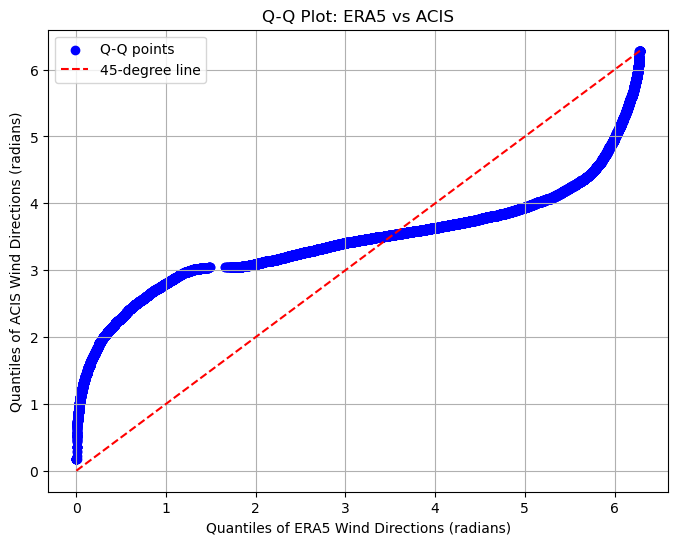

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

def generate_qq_plot(file_path, x_col, y_col):
    """
    Generates a Q-Q plot comparing two sets of quantiles from an Excel file.
    Parameters:
    file_path (str): The path to the Excel file containing the data.
    x_col (str): The column name for the x-axis data (ERA5 Wind Directions).
    y_col (str): The column name for the y-axis data (ECCC Wind Directions).
    """

    data = pd.read_excel(file_path, sheet_name='Sheet2')

    x = data['X rad']
    y = data['Y rad']

    x_sorted = sorted(x)
    y_sorted = sorted(y)

    plt.figure(figsize=(8, 6))
    plt.scatter(x_sorted, y_sorted, c='blue', label='Q-Q points')
    plt.plot([min(x_sorted), max(x_sorted)], [min(x_sorted), max(x_sorted)], color='red', linestyle='--', label='45-degree line')
    plt.title('Q-Q Plot: ERA5 vs ACIS')
    plt.xlabel('Quantiles of ERA5 Wind Directions (radians)')
    plt.ylabel('Quantiles of ACIS Wind Directions (radians)')
    plt.legend()
    plt.grid(True)
    plt.show()

file_path = r'D:\UCalgary_Lectures\GEOG_683\Data_workspace\Daily_multilevel\Windir_1950_2024_Jan\data_stream-oper_BBox_small_masked_ECCC_comparison.xlsx'
# file_path = r'D:\UCalgary_Lectures\GEOG_683\Data_workspace\Daily_multilevel\Windir_1950_2024_Jan\data_stream-oper_BBox_small_masked_ACIS_comparison.xlsx'
generate_qq_plot(file_path, 'X', 'Y')